In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from datetime import timedelta, datetime
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.integrate import odeint
from random import randrange # Obtener un numero randomico
import pygame

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


#### R0 obtenido a partir del SIR

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv')
data = data[data['Country/Region'].isin(['Ecuador'])] #Filtro la Informacion solo para Ecuador
data = data.loc[:,['Date','Confirmed','Recovered']]
formato = '%Y-%m-%d'
date = data['Date']
data['Date'] = date.map(lambda x : (datetime.strptime(x, formato) - datetime.strptime("2020-03-01", formato)).days)

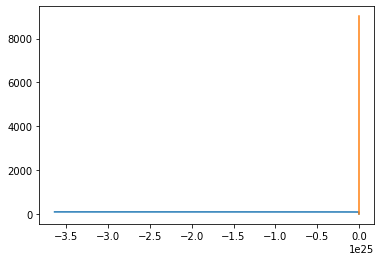

In [3]:
x=np.arange(1,len(data['Date'])+1,1)
y = data.iloc [:, 1]

def func(fx, n, e):
    return (n*np.exp(e*fx))
popt, pcov = curve_fit(func, x, y)

pred_x = np.array(list(range(min(x),max(x)+5)))
plt.plot(func(pred_x ,*popt), pred_x)
plt.plot(x, y)
I00=func(pred_x ,*popt)[-1:]
I0=int(float(I00[0]))

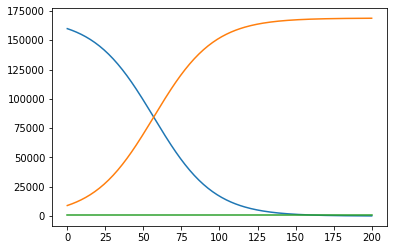

In [4]:
def loss(point, datos, recovered,s0,i0, r0):
    size = len(datos)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s0,i0,r0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - datos)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha =0.1
    return alpha * l1 + (1 - alpha) * l2
#Numero habitantes del Ecuador
N=170000
#casos confirmados
i0=9001
#Recuperados
r0=1000
#Resto de la poblacion
s0= N - i0 - r0
recovered=list(data.iloc [:, 2])
y=list(data.iloc [:, 1])
datos=list(data.iloc [:, 1])
d=[x1 - x2 for (x1, x2) in zip(datos,recovered)]
optimal = minimize(loss, [0.001, 0.001], args=(d, recovered, s0, i0, i0), method='L-BFGS-B', bounds=[(0.0000003, 0.004), (0.00000001, 0.004)])
beta, gamma = optimal.x

R00=(beta/gamma)

new_index =y
size = len(new_index)
numero=len(func(pred_x ,*popt))-len(pred_x)
ea = np.concatenate((y, [None] * (size - len(y))))
er = np.concatenate((func(pred_x ,*popt)[:-numero], [None] * (size - len(func(pred_x ,*popt)[:-numero]))))


t = np.linspace(0, 200,200)
xa=t[0:len(data.iloc [:, 1])]

def deriv(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I 
    dIdt = beta * S * I- gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

y0 = s0,i0,r0

ret = odeint(deriv, y0, t, args=(beta, gamma))

S, I, R = ret.T # Obtenicion de resultados

# S.I.R
plt.plot(t, S)
plt.plot(t, I)
plt.plot(t, R)

In [ ]:
#Parametros de inicio
PROBA_MUERTE = 9.2  # Probabilidad de que la gente muera COVID
CONTAGION_RATE = R00  # Factor R0 para la simulacion COVID probabilidad
PROBA_INFECT = CONTAGION_RATE * 10
PROBA_VACU = 0 # Probabilidad de que exista una vacuna, COVID = 0
SIMULACION_SPEED = 50 # Tiempo de un dia en milisegundos (Cada 25 es un dia)
nb_rows = 50 #Numero de filas
nb_cols = 50 #Numero de columnas

global display, myfont, states, states_temp #Declaracion de variables globales

#Declaro colores en formato RGB
WHITE = (255, 255, 255) 
BLUE = (0, 0, 255)
GREEN = (0, 247, 0)
BLACK = (0, 0, 0)
#Obtiene los vecinos dado un punto x,y
def get_vecinos(x, y):
    incx = randrange(3)
    incy = randrange(3)
    incx = (incx * 1) - 1
    incy = (incy * 1) - 1
    x2 = x + incx
    y2 = y + incy
    #Validar limites
    if x2 < 0:
        x2 = 0
    if x2 >= nb_cols:
        x2 = nb_cols - 1
    if y2 < 0:
        y2 = 0
    if y2 >= nb_rows:
        y2 = nb_rows - 1
    return [x2, y2] # Nuevos contagiados

#Genero las personas que cuentan con inmunidad o vacuna 
def vacunar():
    for x in range(nb_cols):
        for y in range(nb_rows):
            if randrange(99) < PROBA_VACU:
                states[x][y] = 1

#Funcion que permite contar el numero de muertosde la matriz states == -1
def contar_muertes():
    contador = 0
    for x in range(nb_cols):
        for y in range(nb_rows):
            if states[x][y] == -1:
                contador +=  1
    return contador
#Definimos datos de inicio
states = [[0] * nb_cols for i1 in range(nb_rows)]
states_temp = states.copy()
states[randrange(50)][randrange(50)] = 10 # Estado inicial de la simulacion Posicion del Infectado
it = 0 # Variable para contar las Iteraciones
total_muerte = 0 # Contabiliza el numero de muertos
vacunar() #Llamar a la funcion vacunar

pygame.init() #Incializo el motor de juegos pygame
pygame.font.init() #Inicializo el tipo de letra
display=pygame.display.set_mode((800,750),0,32) #Tamanio de la ventana
pygame.display.set_caption("Simulacion de Epidemia Covid-19 Ecuador")# Titulo
font=pygame.font.SysFont('Calibri', 40) # Tipo de letra
display.fill(WHITE) # Color de fondo
while True:
    pygame.time.delay(SIMULACION_SPEED) # Sleep o pausa
    it = it + 1
    if it <= 10000 and it >= 2:
        states_temp = states.copy() #Copia de la matriz
        #Recorrera la matriz
        for x in range(nb_cols):
            for y in range(nb_rows):
                state = states[x][y]
                if state == -1:
                    pass
                if state >= 10: # Numero de dias de contagio
                    states_temp[x][y] = state + 1
                if state >= 20:
                    if randrange(99) < PROBA_MUERTE: # Genero un randomico para verificar si fallece o se recupera
                        states_temp[x][y] = -1 # Muere
                    else:
                        states_temp[x][y] = 1 # Cura o recupera
                if state >= 10 and state <= 20: # Rango de infectado
                    if randrange(99) < PROBA_INFECT: # Infecto a las personas cercanas entre  10 y 20 
                        neighbour = get_vecinos(x, y) #Obtenemos los vecinos a contagiar
                        x2 = neighbour[0]
                        y2 = neighbour[1]
                        neigh_state = states[x2][y2]
                        if neigh_state == 0: #Verifico que este sano
                            states_temp[x2][y2] = 10 # Contagia
        states = states_temp.copy()
        total_muerte = contar_muertes() # contar el numero de muertos
        
    pygame.draw.rect(display, WHITE, (250, 30, 260, 50)) # Grafico el fondo
    textsurface = font.render("Total muertes: "+ str(total_muerte), False, (255,160,122)) #El numero de muertos
    display.blit(textsurface, (250, 30)) # Graficar el texto de muertes
    #Graficar el estado del paciente matriz
    for x in range(nb_cols):
        for y in range(nb_rows):
            if states[x][y] == 0:
                color = BLUE # No infectado
            if states[x][y] == 1:
                color = GREEN # Recupero
            if states[x][y] >= 10:
                color = (states[x][y] * 12, 50, 50) # Injectado - Rojo
            if states[x][y] == -1:
                color = BLACK # Muerto
            pygame.draw.circle(display, color, (100 + x * 12 + 5, 100 + y * 12 + 5), 5)
            pygame.draw.rect(display, WHITE, (100 + x * 12 + 3, 100 + y * 12 + 4, 1, 1))
    #Escuachar los eventos del teclado
    for event in pygame.event.get():
        if event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE: #Presiona y Escape
            pygame.quit() #Termino simulacion
        if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE: #Presiona y espacio
            #Reiniciamos valores
            states = [[0] * nb_cols for i1 in range(nb_rows)]
            states_temp = states.copy()
            states[5][5] = 10
            it = 0
            total_muerte = 0
            vacunar() #Llamar a la funcion vacunar
    pygame.display.update()# Mandar actualizar la ventana

#### Predicción 7 dias

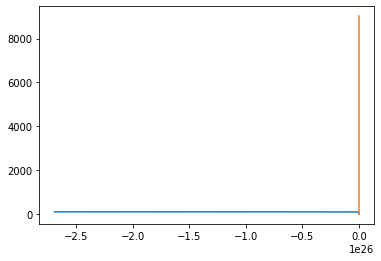

In [5]:
x=np.arange(1,len(data['Date'])+1,1)
y = data.iloc [:, 1]

def func(x, c, k):
    return (c*np.exp(k*x))
popt, pcov = curve_fit(func, x, y)

pred_x = np.array(list(range(min(x),max(x)+7)))
plt.plot(func(pred_x ,*popt), pred_x)
plt.plot(x, y)
I00=func(pred_x ,*popt)[-1:]
I0=int( float(I00[0]) )

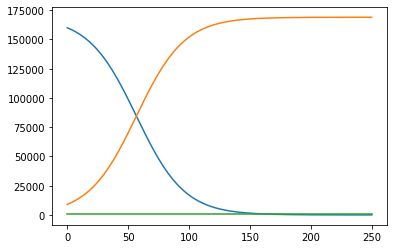

In [6]:
def loss(point, datos, recovered,s0,i0, r0):
    size = len(datos)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s0,i0,r0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - datos)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha =0.1
    return alpha * l1 + (1 - alpha) * l2
#Numero habitantes del Ecuador
#Numero habitantes del Ecuador
N=170000
#casos confirmados
i0=9001
#Recuperados
r0=1000
#Resto de la poblacion
s0= N - i0 - r0
recovered=list(data.iloc [:, 2])
y=list(data.iloc [:, 1])
datos=list(data.iloc [:, 1])
d=[x1 - x2 for (x1, x2) in zip(datos,recovered)]
optimal = minimize(loss, [0.001, 0.001], args=(d, recovered, s0, i0, i0), method='L-BFGS-B', bounds=[(0.0000003, 0.04), (0.0000001, 0.04)])
beta, gamma = optimal.x

R00=beta/gamma

new_index =y
size = len(new_index)
ea = np.concatenate((y, [None] * (size - len(y))))
numero=len(func(pred_x ,*popt))-len(pred_x)
er = er = np.concatenate((func(pred_x ,*popt)[:-numero], [None] * (size - len(func(pred_x ,*popt)[:-numero]))))

t = np.linspace(0, 250,250)
xa=t[0:len(data.iloc [:, 1])]

def deriv(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I 
    dIdt = beta * S * I- gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

y0 = s0,i0,r0

ret = odeint(deriv, y0, t, args=(beta, gamma))

S, I, R = ret.T
plt.plot(t, S)
plt.plot(t, I)
plt.plot(t, R)

In [18]:
#Parametros de inicio
PROBA_MUERTE =9.2  # Probabilidad de que la gente muera COVID
CONTAGION_RATE = 4  # Factor R0 para la simulacion COVID probabilidad
PROBA_INFECT = CONTAGION_RATE * 10
PROBA_VACU = 0 # Probabilidad de que exista una vacuna, COVID = 0
SIMULACION_SPEED = 50 # Tiempo de un dia en milisegundos (Cada 25 es un dia)
nb_rows = 50 #Numero de filas
nb_cols = 50 #Numero de columnas

global display, myfont, states, states_temp #Declaracion de variables globales

#Declaro colores en formato RGB
WHITE = (255, 255, 255) 
BLUE = (0, 0, 255)
GREEN = (0, 247, 0)
BLACK = (0, 0, 0)

#Obtiene los vecinos dado un punto x,y
def get_vecinos(x, y):
    incx = randrange(3)
    incy = randrange(3)
    incx = (incx * 1) - 1
    incy = (incy * 1) - 1
    x2 = x + incx
    y2 = y + incy
    #Validar limites
    if x2 < 0:
        x2 = 0
    if x2 >= nb_cols:
        x2 = nb_cols - 1
    if y2 < 0:
        y2 = 0
    if y2 >= nb_rows:
        y2 = nb_rows - 1
    return [x2, y2] # Nuevos contagiados

#Genero las personas que cuentan con inmunidad o vacuna 
def vacunar():
    for x in range(nb_cols):
        for y in range(nb_rows):
            if randrange(99) < PROBA_VACU:
                states[x][y] = 1

#Funcion que permite contar el numero de muertosde la matriz states == -1
def contar_muertes():
    contador = 0
    for x in range(nb_cols):
        for y in range(nb_rows):
            if states[x][y] == -1:
                contador +=  1
    return contador

#Definimos datos de inicio
states = [[0] * nb_cols for i1 in range(nb_rows)]
states_temp = states.copy()
states[randrange(50)][randrange(50)] = 10 # Estado inicial de la simulacion Posicion del Infectado
it = 0 # Variable para contar las Iteraciones
total_muerte = 0 # Contabiliza el numero de muertos
vacunar() #Llamar a la funcion vacunar

pygame.init() #Incializo el motor de juegos pygame
pygame.font.init() #Inicializo el tipo de letra
display=pygame.display.set_mode((800,750),0,32) #Tamanio de la ventana
pygame.display.set_caption("Simulacion de Epidemia Covid-19 Ecuador")# Titulo
font=pygame.font.SysFont('Calibri', 40) # Tipo de letra
display.fill(WHITE) # Color de fondo

while True:
    pygame.time.delay(SIMULACION_SPEED) # Sleep o pausa
    it = it + 1
    if it <= 10000 and it >= 2:
        states_temp = states.copy() #Copia de la matriz
        #Recorrera la matriz
        for x in range(nb_cols):
            for y in range(nb_rows):
                state = states[x][y]
                if state == -1:
                    pass
                if state >= 10: # Numero de dias de contagio
                    states_temp[x][y] = state + 1
                if state >= 20:
                    if randrange(99) < PROBA_MUERTE: # Genero un randomico para verificar si fallece o se recupera
                        states_temp[x][y] = -1 # Muere
                    else:
                        states_temp[x][y] = 1 # Cura o recupera
                if state >= 10 and state <= 20: # Rango de infectado
                    if randrange(99) < PROBA_INFECT: # Infecto a las personas cercanas entre  10 y 20 
                        neighbour = get_vecinos(x, y) #Obtenemos los vecinos a contagiar
                        x2 = neighbour[0]
                        y2 = neighbour[1]
                        neigh_state = states[x2][y2]
                        if neigh_state == 0: #Verifico que este sano
                            states_temp[x2][y2] = 10 # Contagia
        states = states_temp.copy()
        total_muerte = contar_muertes() # contar el numero de muertos
        
    pygame.draw.rect(display, WHITE, (250, 30, 260, 50)) # Grafico el fondo
    textsurface = font.render("Total muertes: "+ str(total_muerte), False, (255,160,122)) #El numero de muertos
    display.blit(textsurface, (250, 30)) # Graficar el texto de muertes
    #Graficar el estado del paciente matriz
    for x in range(nb_cols):
        for y in range(nb_rows):
            if states[x][y] == 0:
                color = BLUE # No infectado
            if states[x][y] == 1:
                color = GREEN # Recupero
            if states[x][y] >= 10:
                color = (states[x][y] * 12, 50, 50) # Injectado - Rojo
            if states[x][y] == -1:
                color = BLACK # Muerto
            pygame.draw.circle(display, color, (100 + x * 12 + 5, 100 + y * 12 + 5), 5)
            pygame.draw.rect(display, WHITE, (100 + x * 12 + 3, 100 + y * 12 + 4, 1, 1))
    #Escuachar los eventos del teclado
    for event in pygame.event.get():
        if event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE: #Presiona y Escape
            pygame.quit() #Termino simulacion
        if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE: #Presiona y espacio
            #Reiniciamos valores
            states = [[0] * nb_cols for i1 in range(nb_rows)]
            states_temp = states.copy()
            states[5][5] = 10
            it = 0
            total_muerte = 0
            vacunar() #Llamar a la funcion vacunar
            
    pygame.display.update()# Mandar actualizar la ventana

error: video system not initialized

#### R0 con las medidas realizadas por el Ecuador, obtenemos el R0 solo de los dias sin cuarentena y lo evaluan con los las acciones de la cuarentena.

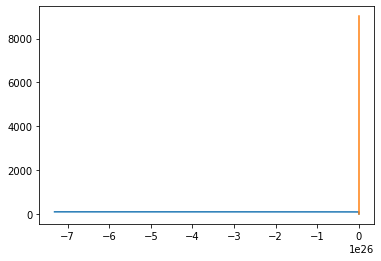

In [15]:
x=np.arange(1,len(data['Date'])+1,1)
y = data.iloc [:, 1]



def func(fx, n, e):
    return (n*np.exp(e*fx))
popt, pcov = curve_fit(func, x, y)

#Predecir para una semana
pred_x = np.array(list(range(min(x),max(x)+8)))
plt.plot(func(pred_x ,*popt), pred_x)
plt.plot(x, y)
I00=func(pred_x ,*popt)[-1:]
I0=int( float(I00[0]) )

#Modelo SIR
def loss(point, datos, recovered,s0,i0, r0):
    size = len(datos)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s0,i0,r0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - datos)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha =0.1
    return alpha * l1 + (1 - alpha) * l2
#Numero habitantes del Ecuador
#Numero habitantes del Ecuador
N=170000
#casos confirmados
i0=9001
#Recuperados
r0=1000
#Resto de la poblacion
s0= N - i0 - r0
recovered=list(data.iloc [:, 2])

y = data.iloc [:, 1]


datos=list(data.iloc [:, 1])

d=[x1 - x2 for (x1, x2) in zip(datos,recovered)]
optimal = minimize(loss, [0.001, 0.001], args=(d, recovered, s0, i0, i0), method='L-BFGS-B', bounds=[(0.00000003, 0.004), (0.00000001, 0.004)])
beta, gamma = optimal.x

R00=(beta/gamma)*1000

new_index =y
size = len(new_index)
ea = np.concatenate((y, [None] * (size - len(y))))
numero=len(func(pred_x ,*popt))-len(pred_x)
er = er = np.concatenate((func(pred_x ,*popt)[:-numero], [None] * (size - len(func(pred_x ,*popt)[:-numero]))))



t = np.linspace(0, 200,200)
xa=t[0:len(data.iloc [:, 1])]
# Las ecuaciones diferenciales del modelo SIR..
def deriv(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I 
    dIdt = beta * S * I- gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt
# Vector de condiciones iniciales
y0 = s0,i0,r0

# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(deriv, y0, t, args=(beta, gamma))

S, I, R = ret.T # Obtenicion de resultados


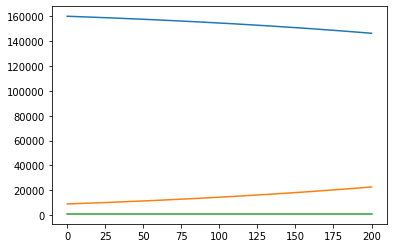

In [13]:
plt.plot(t, S)
plt.plot(t, I)
plt.plot(t, R)

### Conclusiones
###### Gracias a la simpleza modelo S.I.R podemos capturar mucha informacion en este caso sobre Covid-19, de esta manera podemos anticiparnos al futuro de esta pandemia, con cada parametro que vaya variando en el modelo el resultado final sera muy distinto de otro.